In [1]:
# %pylab notebook
%pylab inline
import pandas as pd
import xarray as xr
import glob, re, os
import scipy
# from scipy import io, optimize
import pickle
import datetime
import netCDF4
from mpl_toolkits.basemap import Basemap
# load the notebook import module, refer to $HOME/usr/szhu_setting/python/szpy, set as $PYTHONPATH
from szpy import nbimport
import szpy.sz as sz

## For debug mode
from IPython.core.debugger import Tracer
#Tracer()() #this one triggers the debugger


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons
from importlib import reload
# reload(sz)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Require 'from szpy import nbimport'
ers = __import__('20170523ellipsoid')
# reload(ers)

importing Jupyter notebook from 20170523ellipsoid.ipynb
Populating the interactive namespace from numpy and matplotlib


/home/shichu/usr/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


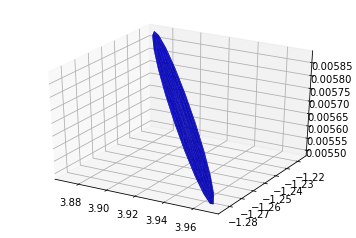

In [3]:
ers.f_plot_E(ers.f_geneigvector(ers.psd))

In [4]:
# Read all source data file for Darwin campaign
# campaign = 'cayenne'
campaign = 'darwin'
sfsrc, ikpsrc, cdpsrc, robsrc, lampsrc = [ xr.open_dataset('tmp/'+campaign+'/'+campaign+'_sync_bulk.nc',group='/'+x)
                      for x in ['saffire','ikp','cdp','robust','lampproc'] ]

rastanamelist = ['w_ret','Mask_Vz','height_2D','w_wind']
rastasrc = xr.merge( [ xr.open_dataset('tmp/'+campaign+'/'+campaign+'_rasta.nc',group='/'+x)
        for x in rastanamelist ] )

mtsatsrc = xr.open_dataset('tmp/'+campaign+'/'+campaign+'_mtsat.nc',group='/mtsatproc',decode_cf=False)
# Note [] {} are comprehension for lsit and dict, while () is a generator, not a tuple compreh
[ mtsatsrc[x].attrs.pop('missing_value') for x in ['longitude','latitude'] ]
mtsatsrc = xr.conventions.decode_cf(mtsatsrc)
mtsatsrc['index'] = xr.DataArray( np.array(range(mtsatsrc.dims['timeutc'])), dims=['timeutc'] )

modelsrc = xr.open_dataset('tmp/'+campaign+'/'+'ecmwf.nc')
sdsrc = xr.open_dataset('tmp/'+campaign+'/'+campaign+'_sync_gz.nc',group='/lamp')
bin_div = sdsrc.bin_div
bin_diff = diff(bin_div)
bin_mid = (bin_div[1:] + bin_div[:-1])/2

/home/shichu/usr/anaconda3/envs/py36/lib/python3.6/site-packages/xarray/conventions.py:838: UserWarning: CF decoding is overwriting dtype
  warnings.warn("CF decoding is overwriting dtype")


In [45]:
# Read all source data file for Cayenne campaign
campaign = 'cayenne'
# campaign = 'darwin'
sfsrc, ikpsrc, cdpsrc, robsrc, lampsrc = [ xr.open_dataset('tmp/'+campaign+'/'+campaign+'_sync_bulk.nc',group='/'+x)
                      for x in ['saffire','ikp','cdp','robust','lampproc'] ]

rastanamelist = ['w_ret','Mask_Vz','height_2D','w_wind']
rastasrc = xr.merge( [ xr.open_dataset('tmp/'+campaign+'/'+campaign+'_rasta.nc',group='/'+x)
        for x in rastanamelist ] )

mtsatsrc = xr.open_dataset('tmp/'+campaign+'/'+campaign+'_mtsat.nc',group='/mtsatproc',decode_cf=True)
# Note [] {} are comprehension for lsit and dict, while () is a generator, not a tuple compreh
mtsatsrc['index'] = xr.DataArray( np.array(range(mtsatsrc.dims['timeutc'])), dims=['timeutc'] )

modelsrc = xr.open_dataset('tmp/'+campaign+'/'+'ecmwf.nc')
sdsrc = xr.open_dataset('tmp/'+campaign+'/'+campaign+'_sync_gz.nc',group='/lamp')
bin_div = sdsrc.bin_div
bin_diff = diff(bin_div)
bin_mid = (bin_div[1:] + bin_div[:-1])/2

In [ ]:
# sf, ikp, cdp, rob, lamp
!/sw/netcdf4-4.2-gnu-4.4.6/bin/ncdump -h tmp/darwin/darwin_sync_bulk.nc

In [ ]:
# rasta
!/sw/netcdf4-4.2-gnu-4.4.6/bin/ncdump -h tmp/darwin/darwin_rasta.nc

In [ ]:
# mtsat
!/sw/netcdf4-4.2-gnu-4.4.6/bin/ncdump -h tmp/darwin/darwin_mtsat.nc
# haha = netCDF4.Dataset('tmp/darwin/darwin_mtsat.nc')
# { x :haha.groups['mtsatproc'].variables[x].long_name 
#  for x in haha.groups['mtsatproc'].variables.keys()
#  if 'long_name' in haha.groups['mtsatproc'].variables[x].ncattrs() }
# haha.close()

In [ ]:
# model
!/sw/netcdf4-4.2-gnu-4.4.6/bin/ncdump -h tmp/darwin/ecmwf.nc

In [46]:
# routine to select a subset of all data except ECMWF model
# selind = np.where(sfsrc.flightnum.values==13)[0]
selind = np.where((ikpsrc.XKBZR5s.values>.5) & (sfsrc.air_temperature_rm.values<-15)  )[0]
#                  & (lampsrc.validbinnum.values>300) )[0]
sf, ikp, cdp, rob, lamp, rasta, mtsat, sd = [ x.isel(timeutc=selind)
    for x in [sfsrc, ikpsrc, cdpsrc, robsrc, lampsrc, rastasrc, mtsatsrc, sdsrc] ]

/data/keeling/a/szhu28/usr/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/data/keeling/a/szhu28/usr/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


In [ ]:
# Create glue files
import h5py
h5f = h5py.File('tmp/glue/ikp.h5', 'w')
data = ikp
a = list(data.keys())
a.remove('timeutc')
i=0
for key in a:
    h5f.create_dataset(key, data=data[key].values)
    i+=1
    print(i,len(a))
h5f.close()

h5f = h5py.File('tmp/glue/sf.h5', 'w')
data = sf
a = list(data.keys())
a.remove('timeutc')
i=0
for key in a:
    h5f.create_dataset(key, data=data[key].values)
    i+=1
    print(i,len(a))
h5f.close()

h5f = h5py.File('tmp/glue/lamp.h5', 'w')
data = lamp
a = list(data.keys())
a.remove('timeutc')
i=0
for key in a:
    if key == 'nml':
        for i,subkey in zip(range(3),['n0','mu','ld']):
            h5f.create_dataset(subkey, data=data[key][:,i].values)
    else:
        h5f.create_dataset(key, data=data[key].values)
    i+=1
    print(i,len(a))
h5f.close()

h5f = h5py.File('tmp/glue/mtsat.h5', 'w')
data = mtsat
a = list(data.keys())
a.remove('timeutc')
a.remove('timelag')
i=0
for key in a:
    h5f.create_dataset(key, data=data[key].values)
    i+=1
    print(i,len(a))
h5f.close()

# Some additional information to facilitate the precision info
h5f = h5py.File('tmp/glue/accessory.h5', 'w')

tmptime = mtsat.timeutc.values
tmptime = (tmptime - tmptime.astype('datetime64[D]')).astype('timedelta64[s]').astype(int)
h5f.create_dataset('timeofday', data=tmptime)
h5f.create_dataset('index', data=mtsat['index'].values)
h5f.create_dataset( 'subsetindex', data=np.array(range(mtsat.dims['timeutc'])) )

h5f.close()

In [ ]:
# saffire vertical wind speed
tmp1 = sf.upward_air_velocity.values
tmp2 = rasta.w_wind.values
plt.scatter(tmp1,tmp2)

In [ ]:
plt.hist(sz.hist(lamp.validbinnum.values))
# plt.show()

In [ ]:
%%capture
%matplotlib notebook
# Required for the next cell
with open('tmp/darwinphasefig.p','rb') as f:
    axb = pickle.load(f)[1]

In [ ]:
# interactive plot of probing the phase space
%matplotlib notebook
# %matplotlib inline

ax = plt.subplot(111, projection='3d')
plt.subplots_adjust(left=0.25, bottom=0.3)
fig = plt.gcf()
x,y,z = lamp.nml.values.T
ax.scatter(x,y,z)
ax.set_xlabel('N0')
ax.set_ylabel('mu')
ax.set_zlabel('lambda')
# The importance of making a copy here. Otherwise xl changes as the ax is changed.
# xl = ax.get_xlim().copy()
# yl = ax.get_ylim().copy()
# zl = ax.get_zlim().copy()
xl = axb.get_xlim().copy()
yl = axb.get_ylim().copy()
zl = axb.get_zlim().copy()

axcolor = 'lightgoldenrodyellow'
axn0 = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
axmu = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)
axld = plt.axes([0.25, 0.2, 0.65, 0.03], facecolor=axcolor)

sn0 = Slider(axn0, 'n0', -100., 100., valinit=0.)
smu = Slider(axmu, 'mu', -100., 100., valinit=0.)
sld = Slider(axld, 'lambda', -100., 100., valinit=0.)

def update(wtfisthis):
    global sn0, smu, sld
    ax.set_xlim(xl+(xl[1]-xl[0])*sn0.val/100)
    ax.set_ylim(yl+(yl[1]-yl[0])*smu.val/100)
    ax.set_zlim(zl+(zl[1]-zl[0])*sld.val/100)
    fig.canvas.draw_idle()
sn0.on_changed(update)
smu.on_changed(update)
sld.on_changed(update)
update(None)

def on_key(event):
    global xl,yl,zl
    if event.key == 'right':
        # The importance of making a copy here. Otherwise xl changes as the ax is changed.
        xl = ax.get_xlim().copy()
        yl = ax.get_ylim().copy()
        zl = ax.get_zlim().copy()
        [ x.set_val(0) for x in [sn0,smu,sld] ]
    elif event.key == 'left':
        [ x.set_val(0) for x in [sn0,smu,sld] ]
cid = fig.canvas.mpl_connect('key_press_event', on_key)

plt.show()

In [ ]:
# %matplotlib inline
%matplotlib notebook
tmp = lamp.nml.values.T
tmp = tmp[:,~any(isnan(tmp),axis=0)]
ers.f_plot_Ef(tmp)
plt.show()

In [ ]:
ind = sf.timeutc[x<-2]

In [ ]:
tmp = sf.sel(timeutc=ind)
tmpikp = ikp.sel(timeutc=ind)
tmpsd = sd.sel(timeutc=ind)

In [ ]:
psd = tmpsd.psddmax.values

In [ ]:
%matplotlib inline
for hehe in psd:
    plt.loglog(bin_mid,hehe)

In [ ]:
# test of interactive plot
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

fig, ax = plt.subplots(figsize=[8,6])
plt.subplots_adjust(left=0.25, bottom=0.25)
t = np.arange(0.0, 1.0, 0.001)
a0 = 5
f0 = 3
s = a0*np.sin(2*np.pi*f0*t)
l, = plt.plot(t, s, lw=2, color='red')
plt.axis([0, 1, -10, 10])

axcolor = 'lightgoldenrodyellow'
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
axamp = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

sfreq = Slider(axfreq, 'Freq', 0.1, 30.0, valinit=f0)
samp = Slider(axamp, 'Amp', 0.1, 10.0, valinit=a0)

def update(val):
    amp = samp.val
    freq = sfreq.val
    l.set_ydata(amp*np.sin(2*np.pi*freq*t))
    fig.canvas.draw_idle()
sfreq.on_changed(update)
samp.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')

def reset(event):
    sfreq.reset()
    samp.reset()
button.on_clicked(reset)

rax = plt.axes([0.025, 0.5, 0.15, 0.15], facecolor=axcolor)
radio = RadioButtons(rax, ('red', 'blue', 'green'), active=0)

def colorfunc(label):
    l.set_color(label)
    fig.canvas.draw_idle()
radio.on_clicked(colorfunc)

keytable = {'left':-1,'right':+1}
def on_key(event):
    sfreq.set_val(sfreq.val+keytable[event.key])
cid = fig.canvas.mpl_connect('key_press_event', on_key)

plt.show()

In [ ]:
# %matplotlib notebook
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(tmp.timeutc,tmp.XKBZR5s.values,'r',label='IWC')
# ax2 = ax1.twinx()
# ax2.plot(tmp.timeutc,tmp.platform_orientation.values,label='yaw')
# plt.legend()

In [ ]:
lon = np.array([110,160])
lat = np.array([-20,10])
m=Basemap(llcrnrlon=np.min(lon),llcrnrlat=np.min(lat),urcrnrlon=np.max(lon),urcrnrlat=np.max(lat),projection='mill')

m.drawmapboundary()
m.drawcoastlines(linewidth=2, color='b')
parallels = np.arange(np.min(lat),np.max(lat),5.)
meridians = np.arange(np.min(lon),np.max(lon),10.)
m.drawparallels(parallels,labels=[True,False,False,False], fontsize=18)
m.drawmeridians(meridians,labels=[False,False,False,True], fontsize=18)

In [ ]:
lon = np.array([110,160])
lat = np.array([-20,10])
m=Basemap(llcrnrlon=np.min(lon),llcrnrlat=np.min(lat),urcrnrlon=np.max(lon),urcrnrlat=np.max(lat),projection='mill')

m.drawmapboundary()
m.drawcoastlines(linewidth=2, color='b')
parallels = np.arange(np.min(lat),np.max(lat),5.)
meridians = np.arange(np.min(lon),np.max(lon),5.)
m.drawparallels(parallels,labels=[True,False,False,False], fontsize=18)
m.drawmeridians(meridians,labels=[False,False,False,True], fontsize=18)